In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import pandas_datareader.data as web
from sklearn.cluster import KMeans
from time import time

In [3]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [4]:
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data

In [5]:
X1.describe()

Attributes    Adj Close             
Symbols           GOOGL          IBM
count       1258.000000  1258.000000
mean          83.327420   115.472707
std           31.585117    10.841204
min           46.714001    79.847000
25%           57.122874   109.069326
50%           69.238003   114.154495
75%          112.697622   124.163923
max          149.838501   141.102219

In [6]:
X2.describe()

,DEXJPUS,DEXUSUK
count,1242.000000,1242.00000
mean,111.860145,1.31101
std,7.691142,0.05883
min,102.520000,1.14190
25%,107.700000,1.27265
50%,109.810000,1.31080
75%,112.775000,1.35620
max,144.390000,1.43320


In [7]:
X3

,SP500,DJIA,VIXCLS
DATE,,,
2017-09-25,2496.66,22296.09,10.21
2017-09-26,2496.84,22284.32,10.17
2017-09-27,2507.04,22340.71,9.87
2017-09-28,2510.06,22381.20,9.55
2017-09-29,2519.36,22405.09,9.51
...,...,...,...
2022-09-16,3873.33,30822.42,26.30
2022-09-19,3899.89,31019.68,25.76
2022-09-20,3855.93,30706.23,27.16


In [8]:
X3.fillna(X3.median(),inplace=True)

In [9]:
X3.describe()

,SP500,DJIA,VIXCLS
count,1304.000000,1304.000000,1304.000000
mean,3373.210176,28533.763643,20.445360
std,677.699559,4058.875267,8.546021
min,2237.400000,18591.930000,9.140000
25%,2801.700000,25361.765000,14.777500
50%,3120.320000,27124.010000,18.760000
75%,3973.842500,32286.805000,24.237500
max,4796.560000,36799.650000,82.690000


In [10]:
scaler = preprocessing.StandardScaler()
X1 = pd.DataFrame(scaler.fit_transform(X1.values),index = X1.index,columns=X1.columns)
X2 = pd.DataFrame(scaler.fit_transform(X2.values),index = X2.index,columns=X2.columns)
X3 = pd.DataFrame(scaler.fit_transform(X3.values),index = X3.index,columns=X3.columns)

In [11]:
backHistory = [30, 45, 60, 90, 180, 240]
BH1, BH2, BH3 = backHistory[1], backHistory[3], backHistory[4]
return_period = BH1
Y = base. shift(-return_period)
X4_BH1 = base.diff( BH1).shift( - BH1)
X4_BH2 = base.diff( BH2).shift( - BH2)
X4_BH3 = base.diff( BH3).shift( - BH3)

X4 = pd.concat([X4_BH1, X4_BH2, X4_BH3], axis=1)
X4.columns = ['X4_BH1', 'X4_BH2', 'X4_BH3']
X4 = pd.DataFrame(scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

In [12]:
X4

,X4_BH1,X4_BH2,X4_BH3
Date,,,
2017-09-25,0.238229,0.144408,-0.149238
2017-09-26,0.154572,-0.000609,-0.133562
2017-09-27,0.167769,0.104622,-0.185041
2017-09-28,0.171577,0.037872,-0.165506
2017-09-29,-0.034679,-0.162270,-0.182320
...,...,...,...
2022-09-16,NaN,NaN,NaN
2022-09-19,NaN,NaN,NaN
2022-09-20,NaN,NaN,NaN


In [13]:
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)

In [14]:
X

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
2017-09-25,-1.159659,-0.510343,-0.028635,0.589904,-1.293916,-1.537388,-1.198135,0.238229,0.144408,-0.149238
2017-09-26,-1.154671,-0.462356,0.039003,0.530386,-1.293651,-1.540289,-1.202817,0.154572,-0.000609,-0.133562
2017-09-27,-1.119086,-0.524950,0.117046,0.494676,-1.278594,-1.526391,-1.237935,0.167769,0.104622,-0.185041
2017-09-28,-1.111310,-0.524950,0.104039,0.552493,-1.274136,-1.516411,-1.275394,0.171577,0.037872,-0.165506
2017-09-29,-1.097200,-0.565287,0.101437,0.496376,-1.260408,-1.510523,-1.280076,-0.034679,-0.162270,-0.182320
...,...,...,...,...,...,...,...,...,...,...
2022-09-16,0.616757,1.088623,4.055628,-2.875734,0.738250,0.564081,0.685335,NaN,NaN,NaN
2022-09-19,0.625308,1.131071,NaN,NaN,0.777456,0.612699,0.622123,NaN,NaN,NaN
2022-09-20,0.564179,0.999114,NaN,NaN,0.712565,0.535444,0.786005,NaN,NaN,NaN
2022-09-21,0.505267,0.872694,NaN,NaN,0.615139,0.406677,0.883164,NaN,NaN,NaN


In [15]:
Y

Date
2017-09-25    80.158028
2017-09-26    78.703697
2017-09-27    79.487503
2017-09-28    79.572510
2017-09-29    76.569412
                ...    
2022-09-16          NaN
2022-09-19          NaN
2022-09-20          NaN
2022-09-21          NaN
2022-09-22          NaN
Name: (Adj Close, MSFT), Length: 1258, dtype: float64

In [16]:
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
2017-09-25,80.158028,-1.159659,-0.510343,-0.028635,0.589904,-1.293916,-1.537388,-1.198135,0.238229,0.144408,-0.149238
2017-09-26,78.703697,-1.154671,-0.462356,0.039003,0.530386,-1.293651,-1.540289,-1.202817,0.154572,-0.000609,-0.133562
2017-09-27,79.487503,-1.119086,-0.524950,0.117046,0.494676,-1.278594,-1.526391,-1.237935,0.167769,0.104622,-0.185041
2017-09-28,79.572510,-1.111310,-0.524950,0.104039,0.552493,-1.274136,-1.516411,-1.275394,0.171577,0.037872,-0.165506
2017-09-29,76.569412,-1.097200,-0.565287,0.101437,0.496376,-1.260408,-1.510523,-1.280076,-0.034679,-0.162270,-0.182320
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-16,NaN,0.616757,1.088623,4.055628,-2.875734,0.738250,0.564081,0.685335,NaN,NaN,NaN
2022-09-19,NaN,0.625308,1.131071,NaN,NaN,0.777456,0.612699,0.622123,NaN,NaN,NaN
2022-09-20,NaN,0.564179,0.999114,NaN,NaN,0.712565,0.535444,0.786005,NaN,NaN,NaN
2022-09-21,NaN,0.505267,0.872694,NaN,NaN,0.615139,0.406677,0.883164,NaN,NaN,NaN


In [17]:
dataset = dataset.dropna()

In [18]:
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
2017-09-25,80.158028,-1.159659,-0.510343,-0.028635,0.589904,-1.293916,-1.537388,-1.198135,0.238229,0.144408,-0.149238
2017-09-26,78.703697,-1.154671,-0.462356,0.039003,0.530386,-1.293651,-1.540289,-1.202817,0.154572,-0.000609,-0.133562
2017-09-27,79.487503,-1.119086,-0.524950,0.117046,0.494676,-1.278594,-1.526391,-1.237935,0.167769,0.104622,-0.185041
2017-09-28,79.572510,-1.111310,-0.524950,0.104039,0.552493,-1.274136,-1.516411,-1.275394,0.171577,0.037872,-0.165506
2017-09-29,76.569412,-1.097200,-0.565287,0.101437,0.496376,-1.260408,-1.510523,-1.280076,-0.034679,-0.162270,-0.182320
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,294.607056,2.006792,1.143960,0.375889,0.547391,2.086001,1.938336,-0.340097,-2.968482,-3.242002,-3.639137
2021-12-29,288.573914,2.005779,1.208015,0.404505,0.620513,2.095906,1.960622,-0.409161,-3.355530,-3.680764,-3.677681
2021-12-30,277.672516,1.991384,1.257836,0.430520,0.663026,2.074753,1.938304,-0.364679,-3.832302,-3.375629,-3.608617
2022-01-03,287.219971,1.953091,1.447329,0.443527,0.610310,2.101072,1.984388,-0.450132,-3.021936,-3.763462,-3.638334


In [19]:
dataset.describe()

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,174.906194,-0.205567,-0.223126,-0.338575,0.130736,-0.187757,-0.175576,-0.096388,0.126929,0.151355,0.001336
std,75.416402,0.921420,0.874173,0.357050,0.913578,0.946491,0.965816,1.050836,0.889823,0.875896,0.994072
min,76.569412,-1.159659,-3.287446,-1.214892,-2.751596,-1.676622,-2.450346,-1.323388,-3.832302,-3.763462,-3.677681
25%,104.841660,-0.862360,-0.698881,-0.593148,-0.461011,-0.902782,-0.866662,-0.784919,-0.269089,-0.231869,-0.412160
50%,153.628235,-0.647902,-0.249132,-0.326500,0.052543,-0.586340,-0.506675,-0.361167,0.091076,0.087756,0.053585
75%,230.358643,0.139127,0.261195,-0.081964,0.885793,0.436644,0.365203,0.242854,0.532475,0.590202,0.625636
max,340.882782,2.106610,1.897334,0.554088,2.077850,2.101072,2.037278,7.286259,2.577556,2.210592,2.421412


In [20]:
dataset = dataset.reset_index()
dataset = dataset.drop(columns= ['index'])
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
0,80.158028,-1.159659,-0.510343,-0.028635,0.589904,-1.293916,-1.537388,-1.198135,0.238229,0.144408,-0.149238
1,78.703697,-1.154671,-0.462356,0.039003,0.530386,-1.293651,-1.540289,-1.202817,0.154572,-0.000609,-0.133562
2,79.487503,-1.119086,-0.524950,0.117046,0.494676,-1.278594,-1.526391,-1.237935,0.167769,0.104622,-0.185041
3,79.572510,-1.111310,-0.524950,0.104039,0.552493,-1.274136,-1.516411,-1.275394,0.171577,0.037872,-0.165506
4,76.569412,-1.097200,-0.565287,0.101437,0.496376,-1.260408,-1.510523,-1.280076,-0.034679,-0.162270,-0.182320
...,...,...,...,...,...,...,...,...,...,...,...
1056,294.607056,2.006792,1.143960,0.375889,0.547391,2.086001,1.938336,-0.340097,-2.968482,-3.242002,-3.639137
1057,288.573914,2.005779,1.208015,0.404505,0.620513,2.095906,1.960622,-0.409161,-3.355530,-3.680764,-3.677681
1058,277.672516,1.991384,1.257836,0.430520,0.663026,2.074753,1.938304,-0.364679,-3.832302,-3.375629,-3.608617
1059,287.219971,1.953091,1.447329,0.443527,0.610310,2.101072,1.984388,-0.450132,-3.021936,-3.763462,-3.638334


In [21]:
Y = dataset[dataset.columns[0]]
Y

0        80.158028
1        78.703697
2        79.487503
3        79.572510
4        76.569412
           ...    
1056    294.607056
1057    288.573914
1058    277.672516
1059    287.219971
1060    284.322845
Name: (Adj Close, MSFT), Length: 1061, dtype: float64

In [22]:
X = dataset.drop(dataset.columns[0],axis=1)
X

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
0,-1.159659,-0.510343,-0.028635,0.589904,-1.293916,-1.537388,-1.198135,0.238229,0.144408,-0.149238
1,-1.154671,-0.462356,0.039003,0.530386,-1.293651,-1.540289,-1.202817,0.154572,-0.000609,-0.133562
2,-1.119086,-0.524950,0.117046,0.494676,-1.278594,-1.526391,-1.237935,0.167769,0.104622,-0.185041
3,-1.111310,-0.524950,0.104039,0.552493,-1.274136,-1.516411,-1.275394,0.171577,0.037872,-0.165506
4,-1.097200,-0.565287,0.101437,0.496376,-1.260408,-1.510523,-1.280076,-0.034679,-0.162270,-0.182320
...,...,...,...,...,...,...,...,...,...,...
1056,2.006792,1.143960,0.375889,0.547391,2.086001,1.938336,-0.340097,-2.968482,-3.242002,-3.639137
1057,2.005779,1.208015,0.404505,0.620513,2.095906,1.960622,-0.409161,-3.355530,-3.680764,-3.677681
1058,1.991384,1.257836,0.430520,0.663026,2.074753,1.938304,-0.364679,-3.832302,-3.375629,-3.608617
1059,1.953091,1.447329,0.443527,0.610310,2.101072,1.984388,-0.450132,-3.021936,-3.763462,-3.638334


In [23]:
data = X.corr()
data

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
"(Adj Close, GOOGL)",1.000000,0.486192,0.094845,0.483430,0.982740,0.952258,0.047198,0.040460,-0.059934,-0.370752
"(Adj Close, IBM)",0.486192,1.000000,0.236112,0.588217,0.506262,0.589115,-0.532156,-0.002491,-0.047912,-0.375536
DEXJPUS,0.094845,0.236112,1.000000,0.077120,0.011478,0.057563,-0.407793,-0.287385,-0.428954,-0.575813
DEXUSUK,0.483430,0.588217,0.077120,1.000000,0.486225,0.528740,-0.304232,0.063434,0.026694,-0.199002
SP500,0.982740,0.506262,0.011478,0.486225,1.000000,0.982879,0.002491,0.011353,-0.035838,-0.281078
DJIA,0.952258,0.589115,0.057563,0.528740,0.982879,1.000000,-0.126383,-0.007451,-0.029897,-0.270801
VIXCLS,0.047198,-0.532156,-0.407793,-0.304232,0.002491,-0.126383,1.000000,0.284879,0.338162,0.259857
X4_BH1,0.040460,-0.002491,-0.287385,0.063434,0.011353,-0.007451,0.284879,1.000000,0.654932,0.389448
X4_BH2,-0.059934,-0.047912,-0.428954,0.026694,-0.035838,-0.029897,0.338162,0.654932,1.000000,0.671268
X4_BH3,-0.370752,-0.375536,-0.575813,-0.199002,-0.281078,-0.270801,0.259857,0.389448,0.671268,1.000000


<AxesSubplot:>

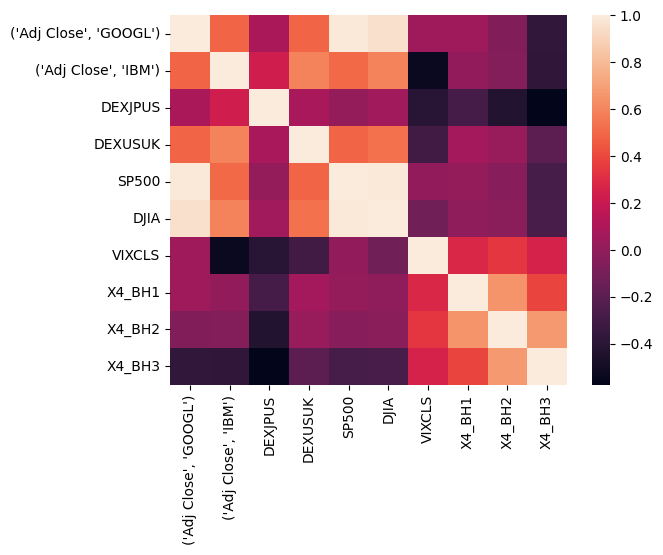

In [24]:
sns.heatmap(data)

In [25]:
lower = pd.DataFrame(np.tril(data, -1),columns = data.columns)
lower

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.486192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.094845,0.236112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.483430,0.588217,0.077120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.982740,0.506262,0.011478,0.486225,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.952258,0.589115,0.057563,0.528740,0.982879,0.000000,0.000000,0.000000,0.000000,0.0
6,0.047198,-0.532156,-0.407793,-0.304232,0.002491,-0.126383,0.000000,0.000000,0.000000,0.0
7,0.040460,-0.002491,-0.287385,0.063434,0.011353,-0.007451,0.284879,0.000000,0.000000,0.0
8,-0.059934,-0.047912,-0.428954,0.026694,-0.035838,-0.029897,0.338162,0.654932,0.000000,0.0
9,-0.370752,-0.375536,-0.575813,-0.199002,-0.281078,-0.270801,0.259857,0.389448,0.671268,0.0


In [26]:
to_drop = [column for column in lower if any(lower[column] > 0.9)]
X.drop(to_drop, inplace=True, axis=1)
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,X4_BH1,X4_BH2,X4_BH3
0,-0.510343,-0.028635,0.589904,-1.537388,-1.198135,0.238229,0.144408,-0.149238
1,-0.462356,0.039003,0.530386,-1.540289,-1.202817,0.154572,-0.000609,-0.133562
2,-0.524950,0.117046,0.494676,-1.526391,-1.237935,0.167769,0.104622,-0.185041
3,-0.524950,0.104039,0.552493,-1.516411,-1.275394,0.171577,0.037872,-0.165506
4,-0.565287,0.101437,0.496376,-1.510523,-1.280076,-0.034679,-0.162270,-0.182320
...,...,...,...,...,...,...,...,...
1056,1.143960,0.375889,0.547391,1.938336,-0.340097,-2.968482,-3.242002,-3.639137
1057,1.208015,0.404505,0.620513,1.960622,-0.409161,-3.355530,-3.680764,-3.677681
1058,1.257836,0.430520,0.663026,1.938304,-0.364679,-3.832302,-3.375629,-3.608617
1059,1.447329,0.443527,0.610310,1.984388,-0.450132,-3.021936,-3.763462,-3.638334


In [27]:
Test_size_op1 = int(np.floor(0.3 * len(X )))
Train_size_op1 = int(np.floor(0.7 * len(X )))
X_train_op1, X_test_op1 = X[0:Train_size_op1], X[Train_size_op1:len(X)]
Y_train_op1, Y_test_op1 = Y[0:Train_size_op1], Y[Train_size_op1:len(X)]

In [28]:
seed = 42
X_train_op2, X_test_op2, Y_train_op2, Y_test_op2 = model_selection.train_test_split(X, Y, test_size=0.3, random_state=seed)

In [29]:
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }

In [30]:
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)

In [31]:
kernel = ['linear', 'rbf', 'poly']
C_list = [10, 100]
ep_list = [0.1, 1, 5]
gamma = [0.01, 0.1]
degree = [2, 3]
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

In [32]:
#a
k = 2
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid = GridSearchCV( estimator=model, n_jobs = 1,verbose = 10,cv = k,scoring = 'neg_mean_squared_error',param_grid=params )

grid_result_a = grid.fit(X_train_op1, Y_train_op1)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2; 1/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear.....
[CV 1/2; 1/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-605.163 total time=   0.0s
[CV 2/2; 1/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear.....
[CV 2/2; 1/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-2104.395 total time=   0.0s
[CV 1/2; 2/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf........
[CV 1/2; 2/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3264.511 total time=   0.0s
[CV 2/2; 2/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf........
[CV 2/2; 2/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-4028.803 total time=   0.0s
[CV 1/2; 3/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.......
[CV 1/2; 3/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-3647.383 total 

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 7/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-571.905 total time=   0.0s
[CV 2/2; 7/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear.......
[CV 2/2; 7/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-2119.886 total time=   0.0s
[CV 1/2; 8/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf..........
[CV 1/2; 8/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-3294.918 total time=   0.0s
[CV 2/2; 8/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf..........
[CV 2/2; 8/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-4033.941 total time=   0.0s
[CV 1/2; 9/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly.........
[CV 1/2; 9/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-3677.186 total time=   0.0s
[CV 2/2; 9/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly.........
[CV 2/2; 9/72] END C=10, degree=2, epsilon=1, gamma=0.01, k

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 16/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-1940.423 total time=   0.0s
[CV 1/2; 17/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 1/2; 17/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-2303.707 total time=   0.0s
[CV 2/2; 17/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 2/2; 17/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-3582.967 total time=   0.0s
[CV 1/2; 18/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly.........
[CV 1/2; 18/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly;, score=-3717.069 total time=   0.0s
[CV 2/2; 18/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly.........
[CV 2/2; 18/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly;, score=-5135.039 total time=   0.0s
[CV 1/2; 19/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=linear....
[CV 1/2; 19/72] END C=10, degree=3, epsilon=0.1, gamma=0.01,

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 24/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-4491.863 total time=   0.0s
[CV 1/2; 25/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear......
[CV 1/2; 25/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-571.905 total time=   0.0s
[CV 2/2; 25/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear......
[CV 2/2; 25/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-2119.886 total time=   0.0s
[CV 1/2; 26/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf.........
[CV 1/2; 26/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-3294.918 total time=   0.0s
[CV 2/2; 26/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf.........
[CV 2/2; 26/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-4033.941 total time=   0.0s
[CV 1/2; 27/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly........
[CV 1/2; 27/72] END C=10, degree=3, epsilon=1, gamma=

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 40/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-527.268 total time=   0.0s
[CV 2/2; 40/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear....
[CV 2/2; 40/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-2043.285 total time=   0.0s
[CV 1/2; 41/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 1/2; 41/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-1196.680 total time=   0.0s
[CV 2/2; 41/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 2/2; 41/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3664.190 total time=   0.0s
[CV 1/2; 42/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 1/2; 42/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-2421.905 total time=   0.0s
[CV 2/2; 42/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 2/2; 42/72] END C=100, degree=2, epsilon

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 44/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-1201.846 total time=   0.0s
[CV 2/2; 44/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf........
[CV 2/2; 44/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-2520.711 total time=   0.0s
[CV 1/2; 45/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly.......
[CV 1/2; 45/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-3540.439 total time=   0.0s
[CV 2/2; 45/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly.......
[CV 2/2; 45/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-5157.856 total time=   0.0s
[CV 1/2; 46/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=linear......
[CV 1/2; 46/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=linear;, score=-543.000 total time=   0.0s
[CV 2/2; 46/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=linear......
[CV 2/2; 46/72] END C=100, degree=2, epsilon=1, gamm

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 49/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-1901.025 total time=   0.0s
[CV 1/2; 50/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf........
[CV 1/2; 50/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-1401.013 total time=   0.0s
[CV 2/2; 50/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf........
[CV 2/2; 50/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-2544.148 total time=   0.0s
[CV 1/2; 51/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly.......
[CV 1/2; 51/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-3510.684 total time=   0.0s
[CV 2/2; 51/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly.......
[CV 2/2; 51/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-5499.480 total time=   0.0s
[CV 1/2; 52/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=linear......
[CV 1/2; 52/72] END C=100, degree=2, epsilon=5, ga

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 61/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-543.000 total time=   0.0s
[CV 2/2; 61/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=linear.....
[CV 2/2; 61/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-2103.633 total time=   0.0s
[CV 1/2; 62/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf........
[CV 1/2; 62/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-1201.846 total time=   0.0s
[CV 2/2; 62/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf........
[CV 2/2; 62/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-2520.711 total time=   0.0s
[CV 1/2; 63/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly.......
[CV 1/2; 63/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-3693.860 total time=   0.0s
[CV 2/2; 63/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly.......
[CV 2/2; 63/72] END C=100, degree=3, epsilon=1, g

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 66/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly;, score=-2941.522 total time=   0.0s
[CV 2/2; 66/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly........
[CV 2/2; 66/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly;, score=-4423.836 total time=   0.0s
[CV 1/2; 67/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear.....
[CV 1/2; 67/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-762.137 total time=   0.0s
[CV 2/2; 67/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear.....
[CV 2/2; 67/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-1901.025 total time=   0.0s
[CV 1/2; 68/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf........
[CV 1/2; 68/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-1401.013 total time=   0.0s
[CV 2/2; 68/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf........
[CV 2/2; 68/72] END C=100, degree=3, epsilon=5, ga

In [33]:
print('Best params: ',grid_result_a.best_params_)
print('Best score: ', grid_result_a.best_score_)

Best params:  {'C': 100, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Best score:  -1285.276697668674


In [34]:
means_a = grid_result_a.cv_results_['mean_test_score']
stds_a = grid_result_a.cv_results_['std_test_score']
params_a = grid_result_a.cv_results_['params']
lables_a = 0
for mean_a, stdev_a, param_a in zip(means_a, stds_a, params_a):
    lables_a = lables_a+1
    print("%f (%f) with: %r" % (mean_a, stdev_a, param_a))
lables_a

-1354.779333 (749.616156) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
-3646.657003 (382.145985) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
-4462.393683 (815.011006) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
-1354.779333 (749.616156) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
-2876.765730 (806.129049) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
-4268.445882 (623.019168) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
-1345.895566 (773.990717) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'linear'}
-3664.429637 (369.511318) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-4497.968002 (820.782095) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'poly'}
-1345.895566 (773.990717) with: {'C': 10, 'degree': 2, 'epsilon': 1, '

72

In [35]:
#b
k = 2
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid = GridSearchCV( estimator=model, n_jobs = 1,verbose = 10,cv = k,scoring = 'neg_mean_squared_error',param_grid=params )

grid_result_b = grid.fit(X_train_op2, Y_train_op2)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2; 1/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear.....
[CV 1/2; 1/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-219.053 total time=   0.0s
[CV 2/2; 1/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear.....
[CV 2/2; 1/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-259.549 total time=   0.0s
[CV 1/2; 2/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf........
[CV 1/2; 2/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1027.138 total time=   0.0s
[CV 2/2; 2/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf........
[CV 2/2; 2/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1467.589 total time=   0.0s
[CV 1/2; 3/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.......
[CV 1/2; 3/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5361.956 total t

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 7/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-254.189 total time=   0.0s
[CV 1/2; 8/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf..........
[CV 1/2; 8/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-1026.846 total time=   0.0s
[CV 2/2; 8/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf..........
[CV 2/2; 8/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-1458.839 total time=   0.0s
[CV 1/2; 9/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly.........
[CV 1/2; 9/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-5356.929 total time=   0.0s
[CV 2/2; 9/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly.........
[CV 2/2; 9/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-6860.714 total time=   0.0s
[CV 1/2; 10/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=linear.......
[CV 1/2; 10/72] END C=10, degree=2, epsilon=1, gamma=0.1, ker

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 14/72] END C=10, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-1480.708 total time=   0.0s
[CV 1/2; 15/72] START C=10, degree=2, epsilon=5, gamma=0.01, kernel=poly........
[CV 1/2; 15/72] END C=10, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-5348.815 total time=   0.0s
[CV 2/2; 15/72] START C=10, degree=2, epsilon=5, gamma=0.01, kernel=poly........
[CV 2/2; 15/72] END C=10, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-6851.556 total time=   0.0s
[CV 1/2; 16/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear.......
[CV 1/2; 16/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-219.804 total time=   0.0s
[CV 2/2; 16/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear.......
[CV 2/2; 16/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-243.728 total time=   0.0s
[CV 1/2; 17/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 1/2; 17/72] END C=10, degree=2, epsilon=5, gamma=0.1

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 20/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1027.138 total time=   0.0s
[CV 2/2; 20/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf.......
[CV 2/2; 20/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1467.589 total time=   0.0s
[CV 1/2; 21/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 1/2; 21/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5702.277 total time=   0.0s
[CV 2/2; 21/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 2/2; 21/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-7239.259 total time=   0.0s
[CV 1/2; 22/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear.....
[CV 1/2; 22/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-219.053 total time=   0.0s
[CV 2/2; 22/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear.....
[CV 2/2; 22/72] END C=10, degree=3, epsilon=0.1

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 27/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-7214.329 total time=   0.0s
[CV 1/2; 28/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=linear.......
[CV 1/2; 28/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-218.861 total time=   0.0s
[CV 2/2; 28/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=linear.......
[CV 2/2; 28/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-254.189 total time=   0.0s
[CV 1/2; 29/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=rbf..........
[CV 1/2; 29/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=rbf;, score=-226.065 total time=   0.0s
[CV 2/2; 29/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=rbf..........
[CV 2/2; 29/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=rbf;, score=-134.330 total time=   0.0s
[CV 1/2; 30/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=poly.........
[CV 1/2; 30/72] END C=10, degree=3, epsilon=1, gamma=0.1, ker

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 37/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-249.808 total time=   0.0s
[CV 1/2; 38/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 1/2; 38/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-183.885 total time=   0.0s
[CV 2/2; 38/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 2/2; 38/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-218.099 total time=   0.0s
[CV 1/2; 39/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 1/2; 39/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-3629.839 total time=   0.0s
[CV 2/2; 39/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 2/2; 39/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5092.166 total time=   0.0s
[CV 1/2; 40/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear....


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 40/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-220.646 total time=   0.0s
[CV 2/2; 40/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear....
[CV 2/2; 40/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-249.808 total time=   0.0s
[CV 1/2; 41/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 1/2; 41/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-59.557 total time=   0.0s
[CV 2/2; 41/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 2/2; 41/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-53.143 total time=   0.0s
[CV 1/2; 42/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 1/2; 42/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-546.320 total time=   0.0s
[CV 2/2; 42/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 2/2; 42/72] END C=100, degree=2, epsilon=0.1, 

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 46/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=linear;, score=-252.551 total time=   0.0s
[CV 1/2; 47/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf.........
[CV 1/2; 47/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-57.309 total time=   0.0s
[CV 2/2; 47/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf.........
[CV 2/2; 47/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-54.185 total time=   0.0s
[CV 1/2; 48/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly........
[CV 1/2; 48/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-545.634 total time=   0.0s
[CV 2/2; 48/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly........
[CV 2/2; 48/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-546.268 total time=   0.0s
[CV 1/2; 49/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear.....


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 49/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-222.343 total time=   0.0s
[CV 2/2; 49/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear.....
[CV 2/2; 49/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-242.311 total time=   0.0s
[CV 1/2; 50/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf........
[CV 1/2; 50/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-182.149 total time=   0.0s
[CV 2/2; 50/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf........
[CV 2/2; 50/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-216.610 total time=   0.0s
[CV 1/2; 51/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly.......
[CV 1/2; 51/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-3656.948 total time=   0.0s
[CV 2/2; 51/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly.......
[CV 2/2; 51/72] END C=100, degree=2, epsilon=5, gamm

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 55/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear;, score=-249.808 total time=   0.0s
[CV 1/2; 56/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 1/2; 56/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-183.885 total time=   0.0s
[CV 2/2; 56/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 2/2; 56/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-218.099 total time=   0.0s
[CV 1/2; 57/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 1/2; 57/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5359.340 total time=   0.0s
[CV 2/2; 57/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 2/2; 57/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-6806.837 total time=   0.0s
[CV 1/2; 58/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear....


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 58/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-220.646 total time=   0.0s
[CV 2/2; 58/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear....
[CV 2/2; 58/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-249.808 total time=   0.0s
[CV 1/2; 59/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 1/2; 59/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-59.557 total time=   0.0s
[CV 2/2; 59/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 2/2; 59/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-53.143 total time=   0.0s
[CV 1/2; 60/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 1/2; 60/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-451.358 total time=   0.0s
[CV 2/2; 60/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 2/2; 60/72] END C=100, degree=3, epsilon=0.1, 

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 62/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-182.862 total time=   0.0s
[CV 2/2; 62/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf........
[CV 2/2; 62/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-219.797 total time=   0.0s
[CV 1/2; 63/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly.......
[CV 1/2; 63/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-5365.707 total time=   0.0s
[CV 2/2; 63/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly.......
[CV 2/2; 63/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-6823.707 total time=   0.0s
[CV 1/2; 64/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear......
[CV 1/2; 64/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-221.729 total time=   0.0s
[CV 2/2; 64/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear......
[CV 2/2; 64/72] END C=100, degree=3, epsilon=1, gamma=

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 67/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-222.343 total time=   0.0s
[CV 2/2; 67/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear.....
[CV 2/2; 67/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-242.311 total time=   0.0s
[CV 1/2; 68/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf........
[CV 1/2; 68/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-182.149 total time=   0.0s
[CV 2/2; 68/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf........
[CV 2/2; 68/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-216.610 total time=   0.0s
[CV 1/2; 69/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly.......
[CV 1/2; 69/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly;, score=-5343.648 total time=   0.0s
[CV 2/2; 69/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly.......
[CV 2/2; 69/72] END C=100, degree=3, epsilon=5, gamm

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

In [36]:
print('Best params: ',grid_result_b.best_params_)
print('Best score: ', grid_result_b.best_score_)

Best params:  {'C': 100, 'degree': 2, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  -55.746830474538214


In [37]:
means_b = grid_result_b.cv_results_['mean_test_score']
stds_b = grid_result_b.cv_results_['std_test_score']
params_b = grid_result_b.cv_results_['params']
lables_b = 0
for mean_b, stdev_b, param_b in zip(means_b, stds_b, params_b):
    lables_b = lables_b+1
    print("%f (%f) with: %r" % (mean_b, stdev_b, param_b))
lables_b

-239.301163 (20.247683) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
-1247.363701 (220.225701) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
-6118.238312 (756.282218) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
-239.301163 (20.247683) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
-180.829350 (44.918100) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
-1079.897209 (38.923452) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
-236.525083 (17.663970) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'linear'}
-1242.842454 (215.996792) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-6108.821212 (751.892701) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'poly'}
-236.525083 (17.663970) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.1

72

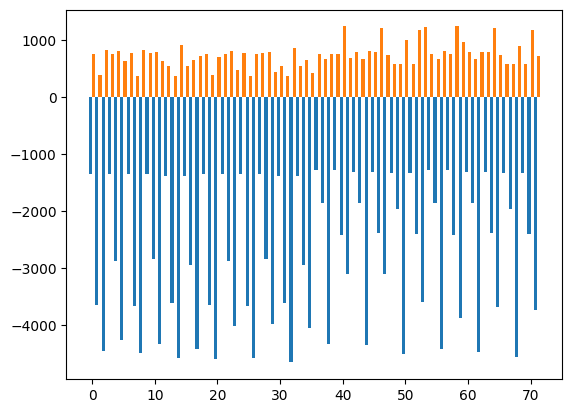

In [38]:
lb_a = []
for i in range(lables_a):
    lb_a.append(i)
x = np.arange(len(lb_a))  
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_a, width, label='means')
rects2 = ax.bar(x + width/2, stds_a, width, label='stds')

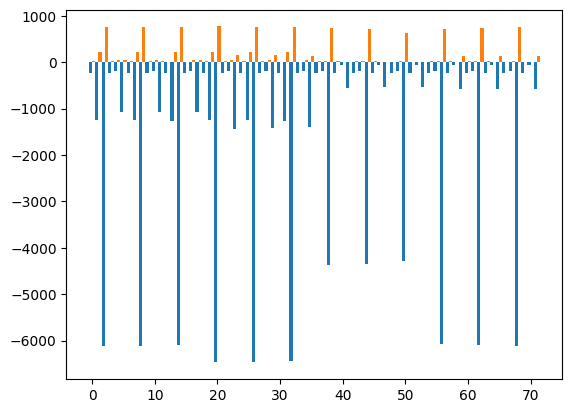

In [39]:
lb_b = []
for i in range(lables_b):
    lb_b.append(i)
x = np.arange(len(lb_b))  
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_b, width, label='means')
rects2 = ax.bar(x + width/2, stds_b, width, label='stds')

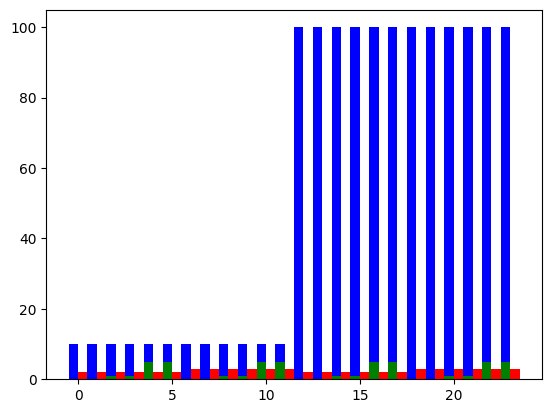

In [73]:
from turtle import color


list_linear_a = []
for i in range(len(params_a)):
    if params_a[i]['kernel'] == 'linear':
        list_linear_a.append(params_a[i])
list_linear_a

list_linear_C_a = []
list_linear_degree_a = []
list_linear_epsilon_a = []
list_linear_gamma_a = []
for i in range(len(list_linear_a)):
    list_linear_C_a.append(list_linear_a[i]['C'])
    list_linear_degree_a.append(list_linear_a[i]['degree'])
    list_linear_epsilon_a.append(list_linear_a[i]['epsilon'])
    list_linear_gamma_a.append(list_linear_a[i]['gamma'])

x = np.arange(len(list_linear_C_a))  
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list_linear_C_a, width,color = 'blue' , label='C')
rects2 = ax.bar(x + width/2, list_linear_degree_a, width,color = 'red' ,label='degree')
rects1 = ax.bar(x - width/2, list_linear_epsilon_a, width,color = 'green', label='epsilon')
rects2 = ax.bar(x + width/2, list_linear_gamma_a, width,color = 'yellow', label='gamma')


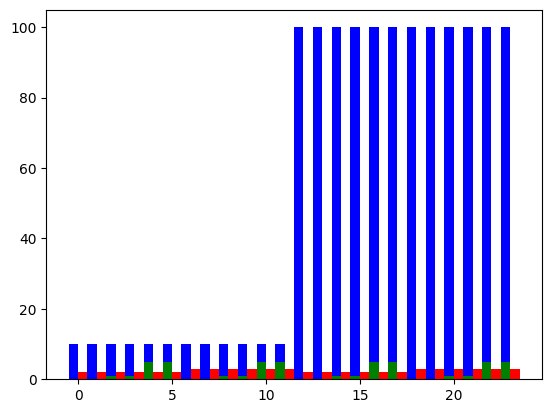

In [75]:
list_rbf_a = []
for i in range(len(params_a)):
    if params_a[i]['kernel'] == 'rbf':
        list_rbf_a.append(params_a[i])
list_rbf_a

list_rbf_C_a = []
list_rbf_degree_a = []
list_rbf_epsilon_a = []
list_rbf_gamma_a = []
for i in range(len(list_rbf_a)):
    list_rbf_C_a.append(list_rbf_a[i]['C'])
    list_rbf_degree_a.append(list_rbf_a[i]['degree'])
    list_rbf_epsilon_a.append(list_rbf_a[i]['epsilon'])
    list_rbf_gamma_a.append(list_rbf_a[i]['gamma'])

x = np.arange(len(list_rbf_C_a))  
width = 0.5

fig, ax_00 = plt.subplots()
rects1 = ax_00.bar(x - width/2, list_rbf_C_a, width,color = 'blue' , label='C')
rects2 = ax_00.bar(x + width/2, list_rbf_degree_a, width,color = 'red' ,label='degree')
rects1 = ax_00.bar(x - width/2, list_rbf_epsilon_a, width,color = 'green', label='epsilon')
rects2 = ax_00.bar(x + width/2, list_rbf_gamma_a, width,color = 'yellow', label='gamma')

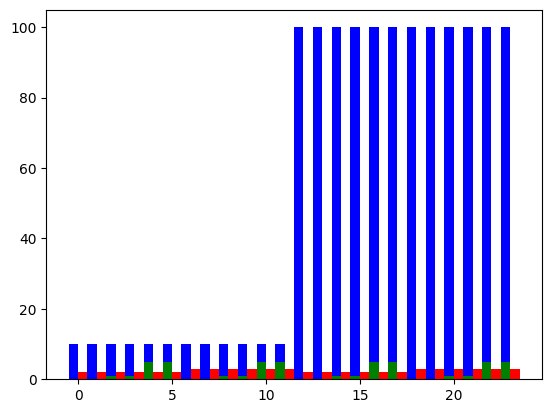

In [76]:
list_poly_a = []
for i in range(len(params_a)):
    if params_a[i]['kernel'] == 'rbf':
        list_poly_a.append(params_a[i])
list_poly_a

list_poly_C_a = []
list_poly_degree_a = []
list_poly_epsilon_a = []
list_poly_gamma_a = []
for i in range(len(list_poly_a)):
    list_poly_C_a.append(list_poly_a[i]['C'])
    list_poly_degree_a.append(list_poly_a[i]['degree'])
    list_poly_epsilon_a.append(list_poly_a[i]['epsilon'])
    list_poly_gamma_a.append(list_poly_a[i]['gamma'])

x = np.arange(len(list_poly_C_a))  
width = 0.5

fig, ax_00 = plt.subplots()
rects1 = ax_00.bar(x - width/2, list_poly_C_a, width,color = 'blue' , label='C')
rects2 = ax_00.bar(x + width/2, list_poly_degree_a, width,color = 'red' ,label='degree')
rects1 = ax_00.bar(x - width/2, list_poly_epsilon_a, width,color = 'green', label='epsilon')
rects2 = ax_00.bar(x + width/2, list_poly_gamma_a, width,color = 'yellow', label='gamma')

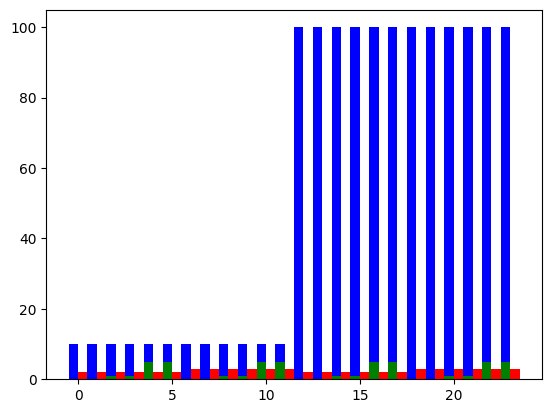

In [77]:

list_linear_b = []
for i in range(len(params_b)):
    if params_b[i]['kernel'] == 'linear':
        list_linear_b.append(params_b[i])
list_linear_b

list_linear_C_b = []
list_linear_degree_b = []
list_linear_epsilon_b = []
list_linear_gamma_b = []
for i in range(len(list_linear_b)):
    list_linear_C_b.append(list_linear_b[i]['C'])
    list_linear_degree_b.append(list_linear_b[i]['degree'])
    list_linear_epsilon_b.append(list_linear_b[i]['epsilon'])
    list_linear_gamma_b.append(list_linear_b[i]['gamma'])

x = np.arange(len(list_linear_C_b))  
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list_linear_C_b, width,color = 'blue' , label='C')
rects2 = ax.bar(x + width/2, list_linear_degree_b, width,color = 'red' ,label='degree')
rects1 = ax.bar(x - width/2, list_linear_epsilon_b, width,color = 'green', label='epsilon')
rects2 = ax.bar(x + width/2, list_linear_gamma_b, width,color = 'yellow', label='gamma')

In [40]:
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)
kernel = ['linear', 'rbf', 'poly']
C_list = list(np.linspace(0.1, 150, 5, dtype = float))
ep_list = list(np.linspace(0.1, 1, 5, dtype = float))
gamma = list(np.linspace(0.01, 0.1, 5, dtype = float))
degree = [2, 3]
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )



C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to s

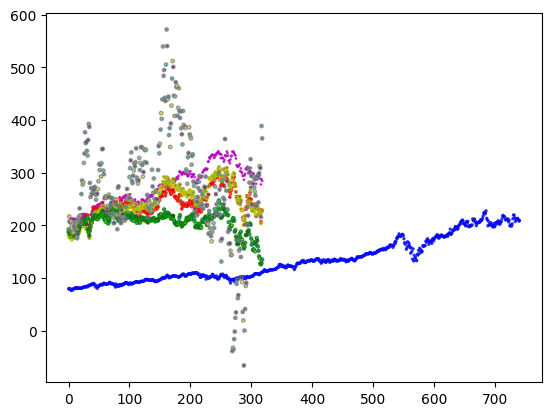

In [78]:
n_clusters=np.unique(Y_test_op1)
kmeans = KMeans(n_clusters= n_clusters.size, random_state=0)
clusters_test = kmeans.fit_predict(X_test_op1)
### y_train
n_clusters=np.unique(Y_train_op1)
kmeans = KMeans(n_clusters= n_clusters.size, random_state=0)
clusters_train = kmeans.fit_predict(X_train_op1)
### LM_pred
Model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LM_pred = Model_LM.fit(X_train_op1, Y_train_op1).predict(X_test_op1)
n_clusters_LM = np.unique(LM_pred)
kmeans_LM = KMeans(n_clusters=n_clusters_LM.size,random_state=0)
clusters_LM = kmeans_LM.fit_predict(X_test_op1)
#svr 
c_val = 100
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
svr_poly = SVR(kernel='poly', C=c_val, degree=3)
SVR_Linear = svr_lin.fit(X_train_op1,Y_train_op1).predict(X_test_op1)
SVR_Rbf = svr_rbf.fit(X_train_op1,Y_train_op1).predict(X_test_op1)
SVR_Poly = svr_poly.fit(X_train_op1,Y_train_op1).predict(X_test_op1)
n_clusters_svr_lin = np.unique(SVR_Linear)
n_clusters_svr_rbf = np.unique(SVR_Rbf)
n_clusters_svr_poly = np.unique(SVR_Poly)
kmeans_lin = KMeans(n_clusters=n_clusters_svr_lin.size,random_state=0)
kmeans_rbf = KMeans(n_clusters=n_clusters_svr_rbf.size,random_state=0)
kmeans_poly = KMeans(n_clusters=n_clusters_svr_poly.size,random_state=0)
clusters_liner = kmeans_lin.fit_predict(X_test_op1)
clusters_rbf = kmeans_rbf.fit_predict(X_test_op1)
clusters_poly = kmeans_poly.fit_predict(X_test_op1)


plt.scatter(np.arange(len(LM_pred)),LM_pred,c=clusters_LM, edgecolors='r',alpha=0.75,s=3)
plt.scatter(np.arange(len(Y_train_op1)),Y_train_op1,c=clusters_train, edgecolors='b',alpha=0.75,s=2)
plt.scatter(np.arange(len(Y_test_op1)),Y_test_op1,c=clusters_test, edgecolors='m',alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Linear)),SVR_Linear,c=clusters_liner, edgecolors='y',alpha=0.75,s=4)
plt.scatter(np.arange(len(SVR_Rbf)),SVR_Rbf,c=clusters_rbf, edgecolors='g',alpha=0.75,s=5)
plt.scatter(np.arange(len(SVR_Poly)),SVR_Poly,c=clusters_poly, edgecolors='grey',alpha=0.75,s=6)

plt.show()


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to s

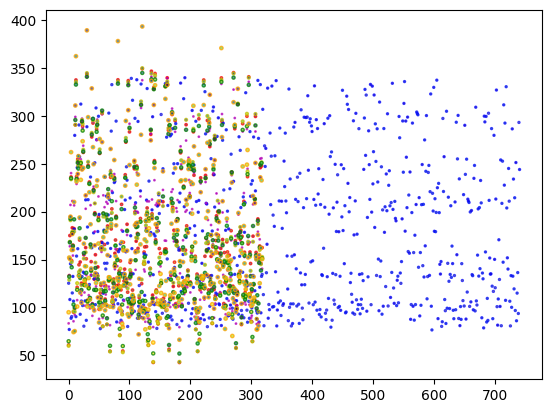

In [42]:
n_clusters=np.unique(Y_test_op2)
kmeans = KMeans(n_clusters= n_clusters.size, random_state=0)
clusters_test = kmeans.fit_predict(X_test_op2)
### y_train
n_clusters=np.unique(Y_train_op2)
kmeans = KMeans(n_clusters= n_clusters.size, random_state=0)
clusters_train = kmeans.fit_predict(X_train_op2)
### LM_pred
Model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LM_pred = Model_LM.fit(X_train_op2, Y_train_op2).predict(X_test_op2)
n_clusters_LM = np.unique(LM_pred)
kmeans_LM = KMeans(n_clusters=n_clusters_LM.size,random_state=0)
clusters_LM = kmeans_LM.fit_predict(X_test_op2)
#svr 
c_val = 100
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)
SVR_Linear = svr_lin.fit(X_train_op2,Y_train_op2).predict(X_test_op2)
SVR_Rbf = svr_rbf.fit(X_train_op2,Y_train_op2).predict(X_test_op2)
SVR_Poly = svr_poly.fit(X_train_op2,Y_train_op2).predict(X_test_op2)
n_clusters_svr_lin = np.unique(SVR_Linear)
n_clusters_svr_rbf = np.unique(SVR_Rbf)
n_clusters_svr_poly = np.unique(SVR_Poly)
kmeans_lin = KMeans(n_clusters=n_clusters_svr_lin.size,random_state=0)
kmeans_rbf = KMeans(n_clusters=n_clusters_svr_rbf.size,random_state=0)
kmeans_poly = KMeans(n_clusters=n_clusters_svr_poly.size,random_state=0)
clusters_liner = kmeans_lin.fit_predict(X_test_op2)
clusters_rbf = kmeans_rbf.fit_predict(X_test_op2)
clusters_poly = kmeans_poly.fit_predict(X_test_op2)


plt.scatter(np.arange(len(LM_pred)),LM_pred,c=clusters_LM, edgecolors='r',alpha=0.75,s=3)
plt.scatter(np.arange(len(Y_train_op2)),Y_train_op2,c=clusters_train, edgecolors='b',alpha=0.75,s=2)
plt.scatter(np.arange(len(Y_test_op2)),Y_test_op2,c=clusters_test, edgecolors='m',alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Linear)),SVR_Linear,c=clusters_liner, edgecolors='y',alpha=0.75,s=4)
plt.scatter(np.arange(len(SVR_Rbf)),SVR_Rbf,c=clusters_rbf, edgecolors='g',alpha=0.75,s=5)
plt.scatter(np.arange(len(SVR_Poly)),SVR_Poly,c=clusters_poly, edgecolors='orange',alpha=0.75,s=6)

plt.show()

In [43]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid_rand = RandomizedSearchCV( estimator=model, n_jobs = 1,verbose = 10,cv = k,scoring = 'neg_mean_squared_error',param_distributions=params )

grid_rand_result_ran_op1 = grid_rand.fit(X_train_op1, Y_train_op1)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START C=150.0, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly..
[CV 1/2; 1/10] END C=150.0, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly;, score=-2423.950 total time=   0.0s
[CV 2/2; 1/10] START C=150.0, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly..
[CV 2/2; 1/10] END C=150.0, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly;, score=-3800.286 total time=   0.0s
[CV 1/2; 2/10] START C=112.525, degree=2, epsilon=0.325, gamma=0.0775, kernel=poly
[CV 1/2; 2/10] END C=112.525, degree=2, epsilon=0.325, gamma=0.0775, kernel=poly;, score=-2659.015 total time=   0.0s
[CV 2/2; 2/10] START C=112.525, degree=2, epsilon=0.325, gamma=0.0775, kernel=poly
[CV 2/2; 2/10] END C=112.525, degree=2, epsilon=0.325, gamma=0.0775, kernel=poly;, score=-3936.919 total time=   0.0s
[CV 1/2; 3/10] START C=75.05, degree=2, epsilon=0.55, gamma=0.05500000000000001, kernel=linear
[CV 1/2; 3/10] END C=75.05, degree=2, epsilon=0.55, 

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 2/2; 5/10] END C=37.575, degree=3, epsilon=0.1, gamma=0.05500000000000001, kernel=rbf;, score=-3244.762 total time=   0.0s
[CV 1/2; 6/10] START C=0.1, degree=2, epsilon=0.775, gamma=0.05500000000000001, kernel=poly
[CV 1/2; 6/10] END C=0.1, degree=2, epsilon=0.775, gamma=0.05500000000000001, kernel=poly;, score=-3847.275 total time=   0.0s
[CV 2/2; 6/10] START C=0.1, degree=2, epsilon=0.775, gamma=0.05500000000000001, kernel=poly
[CV 2/2; 6/10] END C=0.1, degree=2, epsilon=0.775, gamma=0.05500000000000001, kernel=poly;, score=-5327.565 total time=   0.0s
[CV 1/2; 7/10] START C=112.525, degree=3, epsilon=0.775, gamma=0.0775, kernel=rbf
[CV 1/2; 7/10] END C=112.525, degree=3, epsilon=0.775, gamma=0.0775, kernel=rbf;, score=-1008.855 total time=   0.0s
[CV 2/2; 7/10] START C=112.525, degree=3, epsilon=0.775, gamma=0.0775, kernel=rbf
[CV 2/2; 7/10] END C=112.525, degree=3, epsilon=0.775, gamma=0.0775, kernel=rbf;, score=-3479.527 total time=   0.0s
[CV 1/2; 8/10] START C=75.05, degree=

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

In [44]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid_rand = RandomizedSearchCV( estimator=model, n_jobs = 1,verbose = 10,cv = k,scoring = 'neg_mean_squared_error',param_distributions=params )

grid_rand_result_ran_op2 = grid_rand.fit(X_train_op2, Y_train_op2)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START C=75.05, degree=3, epsilon=0.55, gamma=0.1, kernel=poly....
[CV 1/2; 1/10] END C=75.05, degree=3, epsilon=0.55, gamma=0.1, kernel=poly;, score=-493.737 total time=   0.0s
[CV 2/2; 1/10] START C=75.05, degree=3, epsilon=0.55, gamma=0.1, kernel=poly....
[CV 2/2; 1/10] END C=75.05, degree=3, epsilon=0.55, gamma=0.1, kernel=poly;, score=-768.842 total time=   0.0s
[CV 1/2; 2/10] START C=150.0, degree=3, epsilon=0.55, gamma=0.01, kernel=rbf....
[CV 1/2; 2/10] END C=150.0, degree=3, epsilon=0.55, gamma=0.01, kernel=rbf;, score=-169.744 total time=   0.0s
[CV 2/2; 2/10] START C=150.0, degree=3, epsilon=0.55, gamma=0.01, kernel=rbf....
[CV 2/2; 2/10] END C=150.0, degree=3, epsilon=0.55, gamma=0.01, kernel=rbf;, score=-197.899 total time=   0.0s
[CV 1/2; 3/10] START C=37.575, degree=3, epsilon=0.1, gamma=0.01, kernel=poly...
[CV 1/2; 3/10] END C=37.575, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5570.

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.

[CV 1/2; 7/10] END C=75.05, degree=2, epsilon=1.0, gamma=0.01, kernel=linear;, score=-221.679 total time=   0.0s
[CV 2/2; 7/10] START C=75.05, degree=2, epsilon=1.0, gamma=0.01, kernel=linear..
[CV 2/2; 7/10] END C=75.05, degree=2, epsilon=1.0, gamma=0.01, kernel=linear;, score=-252.550 total time=   0.0s
[CV 1/2; 8/10] START C=112.525, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf...
[CV 1/2; 8/10] END C=112.525, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-179.653 total time=   0.0s
[CV 2/2; 8/10] START C=112.525, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf...
[CV 2/2; 8/10] END C=112.525, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-208.719 total time=   0.0s
[CV 1/2; 9/10] START C=37.575, degree=2, epsilon=0.325, gamma=0.01, kernel=linear
[CV 1/2; 9/10] END C=37.575, degree=2, epsilon=0.325, gamma=0.01, kernel=linear;, score=-219.800 total time=   0.0s
[CV 2/2; 9/10] START C=37.575, degree=2, epsilon=0.325, gamma=0.01, kernel=linear
[CV 2/2; 9/10] END C=37.575

In [45]:
# Show Best Parameters for both models
print('Best params: ',grid_rand_result_ran_op1.best_params_)
print('Best score: ', grid_rand_result_ran_op1.best_score_)

Best params:  {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 0.55, 'degree': 2, 'C': 75.05}
Best score:  -1315.3908683693785


In [46]:
print('Best params: ',grid_rand_result_ran_op2.best_params_)
print('Best score: ', grid_rand_result_ran_op2.best_score_)

Best params:  {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.55, 'degree': 2, 'C': 37.575}
Best score:  -112.63626657150425


In [47]:
means_ran_a = grid_rand_result_ran_op1.cv_results_['mean_test_score']
stds_ran_a = grid_rand_result_ran_op1.cv_results_['std_test_score']
params_ran_a = grid_rand_result_ran_op1.cv_results_['params']
lables_ran_a = 0
for mean_ran_a, stdev_ran_a, param_ran_a in zip(means_ran_a, stds_ran_a, params_ran_a):
    lables_ran_a = lables_ran_a+1
    print("%f (%f) with: %r" % (mean_ran_a, stdev_ran_a, param_ran_a))

-3112.118374 (688.168008) with: {'kernel': 'poly', 'gamma': 0.0775, 'epsilon': 1.0, 'degree': 2, 'C': 150.0}
-3297.966908 (638.951777) with: {'kernel': 'poly', 'gamma': 0.0775, 'epsilon': 0.325, 'degree': 2, 'C': 112.525}
-1315.390868 (766.902902) with: {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 0.55, 'degree': 2, 'C': 75.05}
-1316.646266 (772.265048) with: {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 0.55, 'degree': 3, 'C': 37.575}
-2267.395006 (977.366929) with: {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.1, 'degree': 3, 'C': 37.575}
-4587.419949 (740.145171) with: {'kernel': 'poly', 'gamma': 0.05500000000000001, 'epsilon': 0.775, 'degree': 2, 'C': 0.1}
-2244.191384 (1235.336089) with: {'kernel': 'rbf', 'gamma': 0.0775, 'epsilon': 0.775, 'degree': 3, 'C': 112.525}
-2269.350784 (1192.276237) with: {'kernel': 'rbf', 'gamma': 0.0775, 'epsilon': 0.775, 'degree': 2, 'C': 75.05}
-1822.821578 (1023.672236) with: {'kernel': 'rbf', 'gamma':

In [48]:
means_ran_b = grid_rand_result_ran_op2.cv_results_['mean_test_score']
stds__ran_b = grid_rand_result_ran_op2.cv_results_['std_test_score']
params_ran_b = grid_rand_result_ran_op2.cv_results_['params']
lables_ran_b = 0
for mean_ran_b, stdev_ran_b, param_ran_b in zip(means_ran_b, stds__ran_b, params_ran_b):
    lables_ran_b = lables_ran_b+1
    print("%f (%f) with: %r" % (mean_ran_b, stdev_ran_b, param_ran_b))

-631.289363 (137.552753) with: {'kernel': 'poly', 'gamma': 0.1, 'epsilon': 0.55, 'degree': 3, 'C': 75.05}
-183.821625 (14.077752) with: {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.55, 'degree': 3, 'C': 150.0}
-6330.435156 (759.807903) with: {'kernel': 'poly', 'gamma': 0.01, 'epsilon': 0.1, 'degree': 3, 'C': 37.575}
-277.537737 (15.925400) with: {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.325, 'degree': 2, 'C': 37.575}
-1277.912090 (132.910974) with: {'kernel': 'poly', 'gamma': 0.05500000000000001, 'epsilon': 0.1, 'degree': 3, 'C': 75.05}
-2816.630320 (544.185882) with: {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 1.0, 'degree': 3, 'C': 0.1}
-237.114565 (15.435658) with: {'kernel': 'linear', 'gamma': 0.01, 'epsilon': 1.0, 'degree': 2, 'C': 75.05}
-194.186435 (14.533005) with: {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.1, 'degree': 2, 'C': 112.525}
-236.808065 (17.007864) with: {'kernel': 'linear', 'gamma': 0.01, 'epsilon': 0.325, 'degree': 2, 'C': 37.575}
-112.63

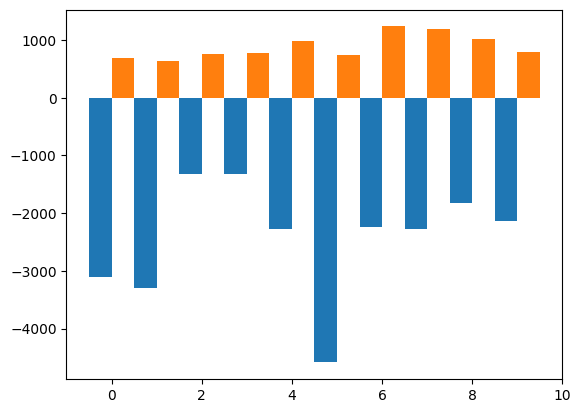

In [49]:
lb_ran_a = []
for i in range(lables_ran_a):
    lb_ran_a.append(i)
x_ran_a = np.arange(len(lb_ran_a))  
width_ran_a = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(x_ran_a - width_ran_a/2, means_ran_a, width_ran_a, label='means')
rects2 = ax.bar(x_ran_a + width_ran_a/2, stds_ran_a, width_ran_a, label='stds')

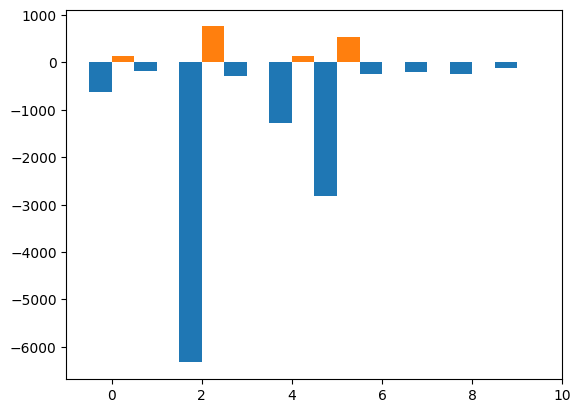

In [50]:
lb_ran_b = []
for i in range(lables_ran_b):
    lb_ran_b.append(i)
x_ran_b = np.arange(len(lb_ran_b))  
width_ran_b = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(x_ran_b - width_ran_b/2, means_ran_b, width_ran_b, label='means')
rects2 = ax.bar(x_ran_b + width_ran_b/2, stds__ran_b, width_ran_b, label='stds')

In [79]:
# Show Best Parameters for both models
print('Best params: ',grid_result_a.best_params_)
print('Best score: ', grid_result_a.best_score_)
print('Best params: ',grid_result_b.best_params_)
print('Best score: ', grid_result_b.best_score_)
# Show Best Parameters for both models
print('Best params: ',grid_rand_result_ran_op1.best_params_)
print('Best score: ', grid_rand_result_ran_op1.best_score_)
print('Best params: ',grid_rand_result_ran_op2.best_params_)
print('Best score: ', grid_rand_result_ran_op2.best_score_)


Best params:  {'C': 100, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Best score:  -1285.276697668674
Best params:  {'C': 100, 'degree': 2, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  -55.746830474538214
Best params:  {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 0.55, 'degree': 2, 'C': 75.05}
Best score:  -1315.3908683693785
Best params:  {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.55, 'degree': 2, 'C': 37.575}
Best score:  -112.63626657150425
